
## Prepare Download dataset

Load credential from drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make directory in local instance

In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download dataset from kaggle

In [ ]:
!kaggle datasets download sriramr/fruits-fresh-and-rotten-for-classification

100% 3.58G/3.58G [00:16<00:00, 270MB/s]
100% 3.58G/3.58G [00:16<00:00, 229MB/s]


unzip dataset

In [ ]:
!unzip -q /content/fruits-fresh-and-rotten-for-classification.zip

In [8]:
!cp -r /content/drive/Shareddrives/Capstone/Dataset/Balanced  /content

# Start

Import necessary library

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

check gpu used

In [22]:
!nvidia-smi

Thu May 26 09:19:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |   2310MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

mapping directory

In [23]:
train_dir = "/content/Balanced"
# train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

Add global variable

In [24]:
NUM_BATCH = 128
NUM_EPOCH = 5
SIZE_IMG = (150, 150)
DIM_IMG = (150, 150, 3)

Add Geneator and image augmentation

In [25]:
train_set = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # validation_split=0.2,
)

val_set = ImageDataGenerator(
    rescale = 1./255,
    # validation_split=0.2,
)

In [26]:
train_data = train_set.flow_from_directory(
    train_dir, 
    target_size =SIZE_IMG,
    shuffle = True,
    class_mode='categorical',
    # subset = 'training',
    batch_size=32,
    seed = 128,
)

# val_data = val_set.flow_from_directory(
#     train_dir, 
#     target_size = SIZE_IMG,
#     shuffle = True,
#     class_mode='categorical',
#     subset = 'validation',
#     batch_size=32,
#     seed = 128,
# )

Found 3519 images belonging to 18 classes.


Load Inception model

In [27]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = 'imagenet') 

In [28]:
fine_tuning = False #@param {type:"boolean"}

if fine_tuning:
    inception_model.trainable = True    
else:
    inception_model.trainable = False

In [29]:
if fine_tuning:
    optimizer = tf.keras.optimizers.SGD(lr=0.002, momentum=0.9)
else:
    optimizer = tf.keras.optimizers.Adam()

In [30]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [31]:
tf.keras.backend.clear_session()

Take the spesific output from layer in pretrained model we desire

In [32]:
last_desired_layer = inception_model.get_layer('mixed7')
print('last layer output shape: ', last_desired_layer.output_shape)
last_output = last_desired_layer.output
print('last layer output: ', last_output)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


Menyusun neural network layer

In [34]:
from keras.layers import Flatten, Dense, Dropout,GlobalMaxPooling2D
from keras import regularizers
from tensorflow.keras import Model

layer = Flatten()(last_output) 
layer = Dense(1024, activation='relu')(layer)
layer = Dropout(0.4)(layer)
layer = Dense(18, activation='softmax')(layer)

model = Model(inputs=inception_model.input, outputs=layer)

model.compile(optimizer=optimizer, metrics=['accuracy'], loss=tf.keras.losses.CategoricalCrossentropy())

Membuat callback

In [35]:
class theCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95):
            print("\n Akurasi mencapai target, stop training")
            self.model.stop_training = True

# Instantiate a callback object
callbacks = theCallback()

Summary and compile

In [36]:
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [38]:
hist = model.fit(train_data, 
                 epochs=10, 
                #  validation_data=val_data, 
                #  steps_per_epoch=128, 
                #  callbacks=[callbacks]
                 )

Epoch 1/10
110/110 [==============================] - 280s 3s/step - loss: 0.8702 - accuracy: 0.7246
Epoch 2/10
110/110 [==============================] - 269s 2s/step - loss: 0.5462 - accuracy: 0.8210
Epoch 3/10
110/110 [==============================] - 268s 2s/step - loss: 0.4464 - accuracy: 0.8556
Epoch 4/10
110/110 [==============================] - 267s 2s/step - loss: 0.4036 - accuracy: 0.8593
Epoch 5/10
110/110 [==============================] - 268s 2s/step - loss: 0.3521 - accuracy: 0.8855
Epoch 6/10
110/110 [==============================] - 267s 2s/step - loss: 0.3390 - accuracy: 0.8897
Epoch 7/10
110/110 [==============================] - 266s 2s/step - loss: 0.2998 - accuracy: 0.8968
Epoch 8/10
110/110 [==============================] - 266s 2s/step - loss: 0.2761 - accuracy: 0.9017
Epoch 9/10
110/110 [==============================] - 267s 2s/step - loss: 0.2764 - accuracy: 0.9054
Epoch 10/10
110/110 [==============================] - 268s 2s/step - loss: 0.2835 - accura

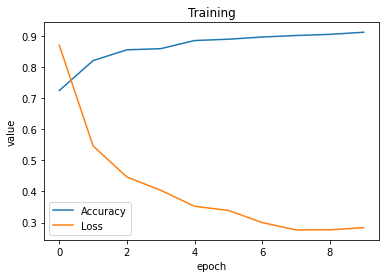

In [39]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['loss'], label='Loss')
plt.title('Training')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend()
plt.show()
# summarize history for loss
# plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
# plt.plot(hist.history['val_loss'], label='Val Los')
# plt.title('Validation')
# plt.ylabel('value')
# plt.xlabel('epoch')
# plt.legend()
# plt.show()

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  y_classes = classes.argmax(axis=-1)
  print(y_classes)
  # if classes[0]>0.5:
  #   print(fn + " is a dog")
  # else:
  #   print(fn + " is a cat")

Saving 1909753989.jpg to 1909753989 (1).jpg
[5]


In [ ]:
import os
def get_prediction_class(model,dataset_dir,image_file):
  clasess = os.listdir(dataset_dir)
  prediction = model.predict(image_file)
  position = np.argmax(prediction)
  
  return prediction[position], clasess[position]

In [ ]:
import numpy as np
from keras.preprocessing import image
np.loadtxt
classes = ['Fresh Apple','Fresh Banana','Fresh Orange','Rotten Apple','Rotten Banana','Rotten Orange']#creating the class labels
test_image = image.load_img('/content/dataset/test/rottenbanana/Screen Shot 2018-06-12 at 9.10.20 PM.png', target_size=(150,150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
confidence, label = get_prediction_class(model, '/content/dataset/train', test_image)
print("The prediction for this image is {}, and the confidence of prediction is {:.2f}%".format(confidence, position))

0
Fresh Apple


In [40]:
RPS_SAVED_MODEL = "rps_saved_model"

In [41]:
tf.saved_model.save(model, RPS_SAVED_MODEL)

INFO:tensorflow:Assets written to: rps_saved_model/assets


In [42]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 150, 150, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 18)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [43]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [44]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'input_1': TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_1')})
{'dense_3': TensorSpec(shape=(None, 18), dtype=tf.float32, name='dense_3')}


In [45]:
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [46]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
!cp /content/converted_model_19052022.tflite /content/drive/Shareddrives/Capstone/Models